## Main task
* Inspect other SOTA models/ architecture within the same problems
* Apply on same test set and make comparison

## 1. Setup notebook

In [ ]:
# !pip install tensorflow
# !pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/ColabNotebooks/COSC2753/patch_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/5088.png   
  inflating: patch_images/5089.png   
  inflating: patch_images/509.png    
  inflating: patch_images/5090.png   
  inflating: patch_images/5091.png   
  inflating: patch_images/5092.png   
  inflating: patch_images/5093.png   
  inflating: patch_images/5094.png   
  inflating: patch_images/5095.png   
  inflating: patch_images/5096.png   
  inflating: patch_images/5097.png   
  inflating: patch_images/5098.png   
  inflating: patch_images/5099.png   
  inflating: patch_images/51.png     
  inflating: patch_images/510.png    
  inflating: patch_images/5100.png   
  inflating: patch_images/5101.png   
  inflating: patch_images/5102.png   
  inflating: patch_images/5103.png   
  inflating: patch_images/5104.png   
  inflating: patch_images/5105.png   
  inflating: patch_images/5106.png   
  inflating: patch_images/5107.png   
  inflating: patch_images/5108.png   
  inflating: patch_images/5116.png   

In [4]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
PATH = "/content/patch_images"

## 2. Data inspecting

### 2.1. Load csv files

In [5]:
%cd "/content/drive/MyDrive/ColabNotebooks/COSC2753"

main_data = pd.read_csv('data_labels_mainData.csv')
main_data

/content/drive/MyDrive/ColabNotebooks/COSC2753


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [6]:
main_data.shape

(9896, 6)

## 3. Data preparation

### 3.1. Split data into train and validation (test) set

In [7]:
from sklearn.model_selection import train_test_split

# Split data into train and validation set
raw_train_df, valid_df = train_test_split(main_data[['ImageName', 'cellType']], test_size=0.3, random_state=9)

print('Train shape:', raw_train_df.shape, 'Validation shape:', valid_df.shape)

Train shape: (6927, 2) Validation shape: (2969, 2)


In [8]:
raw_train_df

,ImageName,cellType
5740,19796.png,1
8131,3475.png,2
8161,3506.png,2
51,19068.png,3
8717,13791.png,3
...,...,...
6200,10244.png,2
501,4103.png,1
6782,3954.png,0
4444,20286.png,1


In [9]:
raw_train_df = raw_train_df.sort_values(by=['cellType']).reset_index(drop = True)
train_X = raw_train_df['ImageName']
train_Y = raw_train_df['cellType']

test_X = valid_df['ImageName']
test_Y = valid_df['cellType']

### 3.2. Create sample image to balance among classes

In [10]:
from random import randint, choice

def create_train_data(directory, img_list, label):
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    count_list = [element for _, element in sorted(zip(item_order, freq_order))] # List of value_counts in cellType

    sum_range = count_list.copy()
    for i in range(1, len(sum_range)):
        sum_range[i] += sum_range[i - 1]

    sum_range.insert(0, 0)
    MAX = max(count_list)
    INTERPOLATION = [cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST]

    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(img_path), (27, 27))
        train_data.append(np.array(img))

    # Add sample data
    for i in range(4):
        if i != 2:
            for j in tqdm(range(MAX - count_list[i]), desc="Sampling class ".format(fc=i)):
                img_path = os.path.join(directory, choice(img_list[sum_range[i]:sum_range[i + 1]]))
                img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])
                train_data.append(np.array(img))


    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

def create_test_data(directory, img_list):
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (27, 27))
        train_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [11]:
def create_test_data(directory, img_list):
    test_data = []
    for name in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(path), (27, 27))
        test_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(test_data).astype('float32') / 255.0 

### 3.3. Create image array

In [12]:
train_X_img = create_train_data(PATH, train_X.to_list(), train_Y)
train_X_img.shape

Sampling class : 100%|██████████| 1947/1947 [00:00<00:00, 9935.89it/s] 


Successfully sample images!


(11588, 27, 27, 3)

In [13]:
test_X_img = create_test_data(PATH, test_X.tolist())
test_X_img.shape

Extracting Image Progress: 100%|██████████| 2969/2969 [00:00<00:00, 11225.15it/s]


Successfully import images!


(2969, 27, 27, 3)

In [14]:
def resampling_label(label):
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    label_modify = label.values
    count_list = [element for _, element in sorted(zip(item_order, freq_order))] # List of value_counts in cellType

    MAX = max(count_list)
    for i in range(4):
        label_modify = np.concatenate((label_modify, np.full((MAX - count_list[i],), i, dtype=int)))

    return label_modify


train_Y_mod = resampling_label(train_Y)
train_Y_mod.shape

(11588,)

In [15]:
test_Y.shape

(2969,)

## 4. Model construction

### 4.1. CIFAR-VGG

The model was taken from [CIFAR100VGG GitHub](https://github.com/geifmany/cifar-vgg/blob/master/cifar100vgg.py)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras import regularizers

weight_decay = 0.0005
VGG = Sequential()  # Initiate the model

# First layer
VGG.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(27,27,3),kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.3))

VGG.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
VGG.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
VGG.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2, 2)))

# Forth layer
VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2, 2)))

VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.5))

# Fully connected layer
VGG.add(Flatten())
VGG.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
VGG.add(Activation('relu'))
VGG.add(BatchNormalization())

VGG.add(Dropout(0.5))
VGG.add(Dense(4))
VGG.add(Activation('softmax'))

VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 27, 27, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 64)        2

### 4.2. Inception (GoogleNet)

The model was taken from this [GitHub](https://github.com/shabbeersh/RCCNet/blob/master/Src/CRC_GoogLeNet.py)

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge,Conv2D,MaxPooling2D,BatchNormalization,Concatenate

input = Input(shape=(27, 27, 3,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(4, activation='softmax')(Output)

GoogleNet = Model(inputs=[input], outputs=[Output])
GoogleNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 27, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 27, 27, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 13, 13, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

### 4.3. ResNet50

The model was taken from this [GitHub](https://github.com/shabbeersh/RCCNet/blob/master/Src/CRC_ResNet50.py)

In [ ]:
from keras.layers import Add
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge,Conv2D,MaxPooling2D,BatchNormalization,Concatenate, Activation

def initial_conv(Input, filters, stride=1, kernel_size=7):
    x = Conv2D(filters, kernel_size=(kernel_size, kernel_size), strides=(stride, stride), padding="same")(Input)

    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x


def expand_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    Init = Input

    # First conv which is used to downsample the image
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])
    return x


def normal_conv_basic_block(Input, filters, stride=1, dropout=0.0):
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Optional Dropout layer
    if (dropout > 0.0):
        x = Dropout(dropout)(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def expand_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    skip_conv = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    skip = BatchNormalization()(skip_conv)

    # Skip connection
    x = Add()([x, skip])

    return x

def normal_conv_bottleneck_block(Input, filters, stride=1, dropout=0.0):
    # Contracting 1*1 conv
    x = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding="same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(dropout > 0.0):
    #   x = Dropout(dropout)(x)

    # Depth preserving 3*3 Conv
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)

    # Expanding 1*1 Conv
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=(stride, stride), padding="same")(x)
    x = BatchNormalization()(x)

    # Identity skip connection
    x = Add()([x, Input])

    return x


def build_basic_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                       first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_basic_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_basic_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_basic_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r4 - 1):
        x = normal_conv_basic_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    # Classifier Block
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def build_bottleneck_resnet(h, w, no_of_outputs, r1, r2, r3, r4, first_conv_stride=2, first_max_pool=True,
                            first_conv_kernel_size=7):
    # Creating input tensor
    inputs = Input(shape=(h, w, 3), name="image_input")

    # Inital Conv block
    x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernel_size)

    # Optional Max pooling layer
    if (first_max_pool):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x, 64, 1)
    x = Activation('relu')(x)

    # Repeating block of Conv1
    for i in range(r1 - 1):
        x = normal_conv_bottleneck_block(x, 64)
        x = Activation('relu')(x)

    # Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x, 128, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv2
    for i in range(r2 - 1):
        x = normal_conv_bottleneck_block(x, 128)
        x = Activation('relu')(x)

    # Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x, 256, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv3
    for i in range(r3 - 1):
        x = normal_conv_bottleneck_block(x, 256)
        x = Activation('relu')(x)

    # Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x, 512, 2)
    x = Activation('relu')(x)

    # Repeating block of Conv4
    for i in range(r4 - 1):
        x = normal_conv_bottleneck_block(x, 512)
        x = Activation('relu')(x)

    shape = K.int_shape(x)

    # Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                         strides=(1, 1))(x)
    # x = GlobalAveragePooling2D()(x)

    # Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

ResNet50 = build_bottleneck_resnet(27,27,4,3,4,6,3,2,True,7)
ResNet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 27, 27, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   9472        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

### 4.4. RCCNet

The model was taken from this [GitHub](https://github.com/shabbeersh/RCCNet/blob/master/Src/RCCNet.py)

In [ ]:
RCC = Sequential()
RCC.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
RCC.add(BatchNormalization())
RCC.add(Conv2D(32, (3, 3), activation='relu'))
RCC.add(BatchNormalization())
RCC.add(MaxPooling2D(pool_size=(2, 2)))

RCC.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
RCC.add(BatchNormalization())
RCC.add(Conv2D(64, (3, 3), activation='relu'))
RCC.add(BatchNormalization())
RCC.add(MaxPooling2D(pool_size=(2, 2)))
RCC.add(Flatten())
RCC.add(Dense(512, activation='relu'))
RCC.add(BatchNormalization())
RCC.add(Dropout(0.2))
RCC.add(Dense(512, activation='relu'))
RCC.add(BatchNormalization())
RCC.add(Dropout(0.2))
RCC.add(Dense(4, activation='softmax'))

RCC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_401 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_220 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_402 (Conv2D)          (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_221 (Bat (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_403 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_222 (Bat (None, 12, 12, 64)       

### 4.5. Softmax CNN

The architecture was reference from "Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images"

In [ ]:
sCNN = Sequential()

sCNN.add(Conv2D(36, (4, 4), activation='relu', input_shape=(27,27, 3)))
sCNN.add(BatchNormalization())
sCNN.add(MaxPooling2D(pool_size=(2, 2)))

sCNN.add(Conv2D(48, (3, 3), activation='relu'))
sCNN.add(BatchNormalization())
sCNN.add(MaxPooling2D(pool_size=(2, 2)))

sCNN.add(Flatten())
sCNN.add(Dense(512, activation='relu'))
sCNN.add(BatchNormalization())
sCNN.add(Dropout(0.2))
sCNN.add(Dense(512, activation='relu'))
sCNN.add(BatchNormalization())
sCNN.add(Dropout(0.2))
sCNN.add(Dense(4, activation='softmax'))

sCNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 24, 24, 36)        1764      
_________________________________________________________________
batch_normalization_65 (Batc (None, 24, 24, 36)        144       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 10, 10, 48)        15600     
_________________________________________________________________
batch_normalization_66 (Batc (None, 10, 10, 48)        192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1200)             

### 4.6. Compile and training

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0005)

sCNN.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

train_datagen = datagen.flow(train_X_img, train_Y_mod, shuffle=True)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 500
BATCH_SIZE = 32

import time
start_time = time.time()

history = sCNN.fit(train_datagen, 
                    validation_data=(test_X_img, test_Y), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1,
                    callbacks=[reduce_lr, early])

print("---  Training time in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
363/363 [==============================] - 3s 6ms/step - loss: 1.1322 - accuracy: 0.5975 - val_loss: 2.5135 - val_accuracy: 0.4870
Epoch 2/500
363/363 [==============================] - 2s 5ms/step - loss: 0.6527 - accuracy: 0.7492 - val_loss: 0.7790 - val_accuracy: 0.7309
Epoch 3/500
363/363 [==============================] - 2s 5ms/step - loss: 0.4996 - accuracy: 0.8121 - val_loss: 2.7177 - val_accuracy: 0.3631
Epoch 4/500
363/363 [==============================] - 2s 5ms/step - loss: 0.3817 - accuracy: 0.8580 - val_loss: 0.9902 - val_accuracy: 0.6672
Epoch 5/500
363/363 [==============================] - 2s 5ms/step - loss: 0.3090 - accuracy: 0.8890 - val_loss: 0.9923 - val_accuracy: 0.6639
Epoch 6/500
363/363 [==============================] - 2s 5ms/step - loss: 0.2318 - accuracy: 0.9138 - val_loss: 1.3095 - val_accuracy: 0.6285
Epoch 7/500
363/363 [==============================] - 2s 5ms/step - loss: 0.2442 - accuracy: 0.9101 - val_loss: 3.0227 - val_accuracy: 0.3826

In [ ]:
from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
export = 'sCNN_{ft}.h5'.format(ft=dt_string)
print(export)

sCNN.save(export)

sCNN_24-05-2021_02-51-34.h5


93/93 [==============================] - 0s 2ms/step - loss: 1.1196 - accuracy: 0.7588
Validation loss: 1.119598627090454
Validation accuracy: 0.758841335773468
Max Validation accuracy: 0.7611990571022034


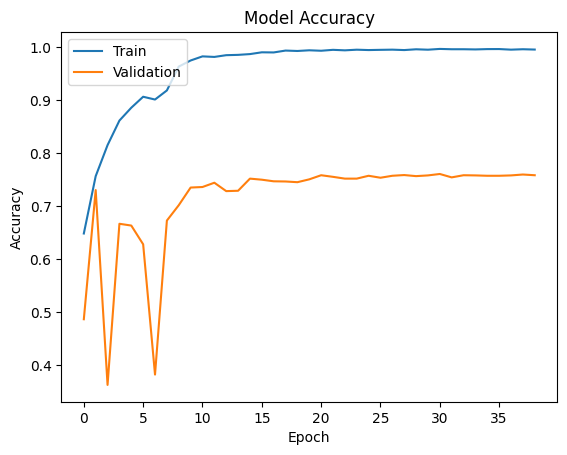

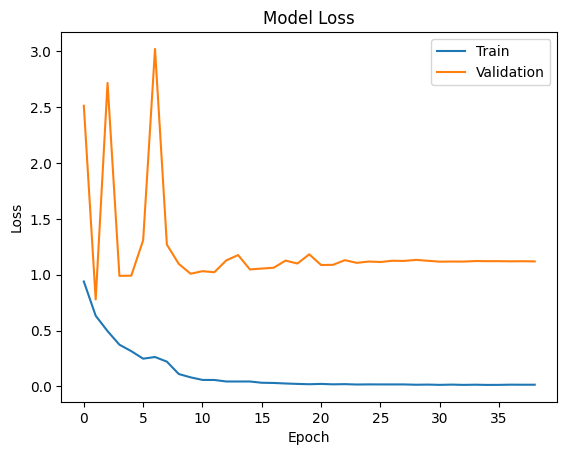

In [ ]:
plt.style.use('default')

scores = sCNN.evaluate(test_X_img, test_Y, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
print('Max Validation accuracy:', max(history.history['val_accuracy']))
# # visualizing losses and accuracy
# print(history.history.keys())
# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predictions = sCNN.predict(test_X_img)
predictions_classes = predictions.argmax(axis=-1)
# predictions = predictions.reshape(1,-1)[0]

print(classification_report(test_Y, predictions_classes, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 0       0.73      0.66      0.70       586
     Class 1       0.70      0.75      0.72       765
     Class 2       0.85      0.91      0.88      1182
     Class 3       0.61      0.50      0.55       436

    accuracy                           0.76      2969
   macro avg       0.72      0.71      0.71      2969
weighted avg       0.75      0.76      0.75      2969



## 5. Model comparison

### 5.1. Load the models

In [16]:
from tensorflow.keras.models import load_model

MKNetMain = load_model('Task2_Main.h5')
MKNetExtra = load_model('Task2_Extra.h5') 
softmaxCNN = load_model('softmaxCNN.h5')
RCC = load_model('RCC.h5') 
GoogleNet = load_model('GoogleNet.h5')
VGG = load_model('CIFAR-VGG.h5')
ResNet50 = load_model('ResNet50.h5')

In [ ]:
# from sklearn.metrics import classification_report

# predictions = ResNet50.predict(test_X_img)
# predictions_classes = predictions.argmax(axis=-1)

# print(classification_report(test_Y, predictions_classes, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 0       0.69      0.65      0.67       586
     Class 1       0.67      0.73      0.70       765
     Class 2       0.84      0.90      0.87      1182
     Class 3       0.51      0.36      0.43       436

    accuracy                           0.73      2969
   macro avg       0.68      0.66      0.67      2969
weighted avg       0.72      0.73      0.72      2969



### 5.2. Calculate the metrics

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# models = [MKNetMain, MKNetExtra, softmaxCNN, RCC, GoogleNet, VGG, ResNet50]

def model_all_metrics(name):
    predictions = name.predict(test_X_img)
    predictions_classes = predictions.argmax(axis=-1)

    arr = []
    arr.append(accuracy_score(test_Y, predictions_classes))
    arr.append(precision_score(test_Y, predictions_classes, average='weighted'))
    arr.append(recall_score(test_Y, predictions_classes, average='weighted' ))
    arr.append(f1_score(test_Y, predictions_classes, average='weighted'))
    print('Model {fm} has evaluated all metrics!'.format(fm = name))
    return arr

m1 = model_all_metrics(MKNetMain)
m2 = model_all_metrics(MKNetExtra)
m3 = model_all_metrics(softmaxCNN)
m4 = model_all_metrics(RCC)
m5 = model_all_metrics(GoogleNet)
m6 = model_all_metrics(VGG)
m7 = model_all_metrics(ResNet50)

Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff606a4dd90> has evaluated all metrics!
Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff5b119e510> has evaluated all metrics!
Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff5a01f3f90> has evaluated all metrics!
Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff5a015df10> has evaluated all metrics!
Model <tensorflow.python.keras.engine.functional.Functional object at 0x7ff5a00ae250> has evaluated all metrics!
Model <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff568782f90> has evaluated all metrics!
Model <tensorflow.python.keras.engine.functional.Functional object at 0x7ff5686e52d0> has evaluated all metrics!


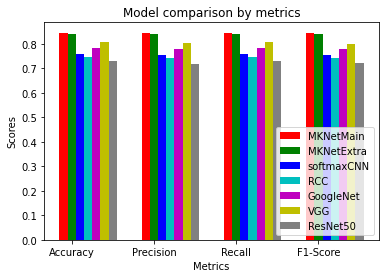

<Figure size 72000x72000 with 0 Axes>

In [34]:
N = 4
ind = np.arange(N) 
width = 0.1

bar1 = plt.bar(ind, m1, width, color = 'r')
bar2 = plt.bar(ind+width, m2, width, color='g')  
bar3 = plt.bar(ind+width*2, m3, width, color = 'b')
bar4 = plt.bar(ind+width*3, m4, width, color = 'c')
bar5 = plt.bar(ind+width*4, m5, width, color = 'm')
bar6 = plt.bar(ind+width*5, m6, width, color = 'y')
bar7 = plt.bar(ind+width*6, m7, width, color = 'gray')

plt.xlabel("Metrics")
plt.ylabel('Scores')
plt.title("Model comparison by metrics")
  
plt.xticks(ind+width,['Accuracy', 'Precision', 'Recall', 'F1-Score'])
plt.legend( (bar1, bar2, bar3, bar4, bar5, bar6, bar7), ('MKNetMain', 'MKNetExtra', 'softmaxCNN','RCC','GoogleNet','VGG','ResNet50'), loc = 'lower right')
plt.figure(figsize=(1000, 1000))
plt.show()